In [ ]:
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import numpy as np

# Load the dataset
training_data = pd.read_excel('/content/Premier_League_Date_Combined_Modified_2.0 - Training Set.xlsx')

# Define the feature columns
features = [
    'LSPR',    # Last Season Possession Ratio
    'LSGFD',   # Last Season Goals For Difference
    'LSGAD',   # Last Season Goals Against Difference
    'LSYCD',   # Last Season Yellow Cards Difference
    'LSPD',    # Last Season Penalty Difference
    'LSSPR',   # Last Season Save Percentage Ratio
    'LSCSPR',  # Last Season Clean Sheet Percentage Ratio
    'R5PD',    # Recent 5 Games Points Difference
    'R5GFD',   # Recent 5 Games Goals For Difference
    'R5GAD',   # Recent 5 Games Goals Against Difference
    'TSSD',    # This Season Squad Difference
    'TSAD',    # This Season Age (Average) Difference
    'TSFD',    # This Season Foreigners Difference
    'TSTMR',   # This Season Total Market Ratio
    'R3VATGD', # Recent 3 Versus Away Team Goals Difference
    'R3VATP'   # Recent 3 Vercus Away Team Points
]

# Define the seasons for forward chaining cross-validation
seasons = ['2015-2016', '2016-2017', '2017-2018', '2018-2019', '2019-2020', '2020-2021', '2021-2022']

# Define a range of n_neighbors to test
n_neighbors_values = list(range(1, 76))

results = []

for n_neighbors in n_neighbors_values:
    print(f"Testing with n_neighbors={n_neighbors}")
    model = KNeighborsClassifier(n_neighbors=n_neighbors)

    fold_results = []

    for i in range(2, len(seasons) - 1):
        # Define training and validation seasons
        train_seasons = seasons[i - 2:i]
        test_season = seasons[i + 1]

        # Filter training and validation data
        X_train = training_data[training_data['Season'].isin(train_seasons)][features]
        y_train = training_data[training_data['Season'].isin(train_seasons)]['Outcome_Label']
        X_test = training_data[training_data['Season'] == test_season][features]
        y_test = training_data[training_data['Season'] == test_season]['Outcome_Label']

        # Standardize the features using only the training data
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Train the model
        model.fit(X_train_scaled, y_train)

        # Test the model
        y_pred = model.predict(X_test_scaled)

        # Evaluate the model
        report = classification_report(y_test, y_pred, output_dict=True)
        accuracy = report['accuracy']
        fold_results.append(accuracy)

    # Average results for this n_neighbors value
    mean_accuracy = np.mean(fold_results)
    results.append({'n_neighbors': n_neighbors, 'Mean Accuracy': mean_accuracy})
    print(f"Mean Accuracy for n_neighbors={n_neighbors}: {mean_accuracy}")

# Find the best n_neighbors value
results_df = pd.DataFrame(results)
best_result = results_df.loc[results_df['Mean Accuracy'].idxmax()]
print(f"\nBest n_neighbors Value: {best_result['n_neighbors']} with Mean Accuracy: {best_result['Mean Accuracy']}")


Testing with n_neighbors=1
Mean Accuracy for n_neighbors=1: 0.41578947368421054
Testing with n_neighbors=2
Mean Accuracy for n_neighbors=2: 0.4013157894736842
Testing with n_neighbors=3
Mean Accuracy for n_neighbors=3: 0.4368421052631579
Testing with n_neighbors=4
Mean Accuracy for n_neighbors=4: 0.4467105263157895
Testing with n_neighbors=5
Mean Accuracy for n_neighbors=5: 0.46184210526315794
Testing with n_neighbors=6
Mean Accuracy for n_neighbors=6: 0.47171052631578947
Testing with n_neighbors=7
Mean Accuracy for n_neighbors=7: 0.4677631578947369
Testing with n_neighbors=8
Mean Accuracy for n_neighbors=8: 0.4789473684210526
Testing with n_neighbors=9
Mean Accuracy for n_neighbors=9: 0.49407894736842106
Testing with n_neighbors=10
Mean Accuracy for n_neighbors=10: 0.4894736842105263
Testing with n_neighbors=11
Mean Accuracy for n_neighbors=11: 0.4881578947368421
Testing with n_neighbors=12
Mean Accuracy for n_neighbors=12: 0.4953947368421052
Testing with n_neighbors=13
Mean Accuracy 

In [ ]:
# Train the final model using the entire training set with the best n_estimators value
X_train = training_data[features]
y_train = training_data['Outcome_Label']

# Standardize the features
scaler = StandardScaler()
X_scaled_train = scaler.fit_transform(X_train)

# Test the model on the entire training set
model = KNeighborsClassifier(n_neighbors=66)
model.fit(X_scaled_train, y_train)
y_pred = model.predict(X_scaled_train)

# Evaluate the model
training_confusion_matrix = confusion_matrix(y_train, y_pred)

print("Training Confusion Matrix:")
print(training_confusion_matrix)

Training Confusion Matrix:
[[465  13 381]
 [202  19 403]
 [202   8 967]]


Test Confusion Matrix:
[[ 70   1  52]
 [ 29   0  53]
 [ 35   4 136]]


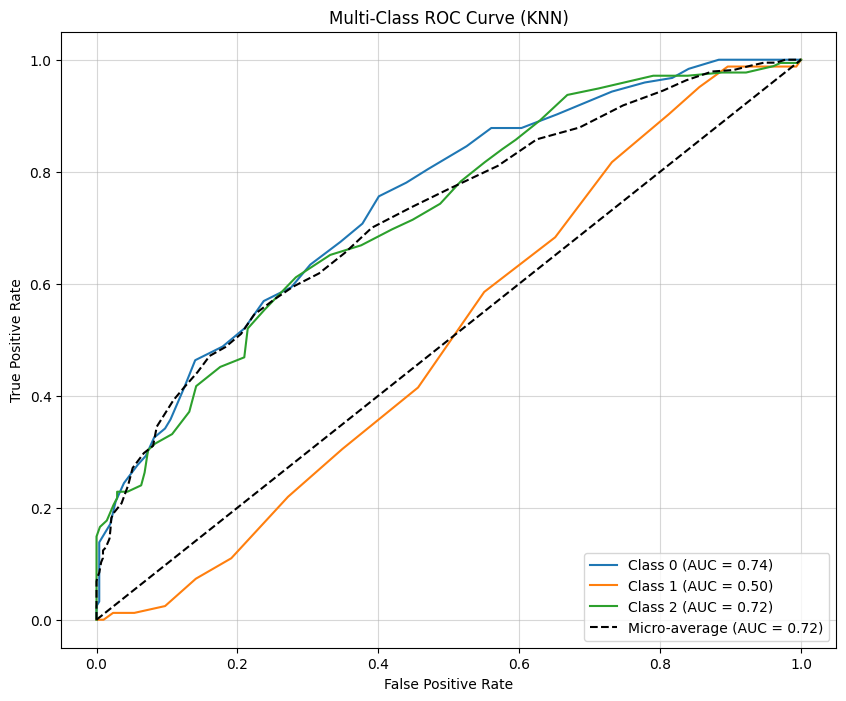

In [ ]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Define the test set (replace with your actual test set file or filtering)
test_data = pd.read_excel('/content/Premier_League_Date_Combined_Modified_2.0 - Testing Set.xlsx')
X_test = test_data[features]
y_test = test_data['Outcome_Label']

# Standardize the test set using the same scaler from training
X_scaled_test = scaler.transform(X_test)

# Predict on the test set
y_pred_test = model.predict(X_scaled_test)
y_prob = model.predict_proba(X_scaled_test)

# Confusion matrix for the test set
test_confusion_matrix = confusion_matrix(y_test, y_pred_test)

print("Test Confusion Matrix:")
print(test_confusion_matrix)

# Binarize the output labels for multi-class AUC
classes = sorted(y_train.unique())
y_test_binarized = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i, class_label in enumerate(classes):
    fpr[class_label], tpr[class_label], _ = roc_curve(y_test_binarized[:, i], y_prob[:, i])
    roc_auc[class_label] = auc(fpr[class_label], tpr[class_label])

# Compute the micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot the ROC curve for each class
plt.figure(figsize=(10, 8))
for class_label in classes:
    plt.plot(
        fpr[class_label],
        tpr[class_label],
        label=f"Class {class_label} (AUC = {roc_auc[class_label]:.2f})"
    )

# Plot the micro-average ROC curve
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"Micro-average (AUC = {roc_auc['micro']:.2f})",
    color="black", linestyle="--"
)

# Plot diagonal
plt.plot([0, 1], [0, 1], "k--")

# Add labels and legend
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-Class ROC Curve (KNN)")
plt.legend(loc="lower right")
plt.grid(alpha=0.5)
plt.show()
